# Job satisfaction

Job satisfaction is a foundamental aspect of modern society, both for personal happiness and companies productivity. This concept was introduced by Robert Hoppock in 1933 as “The combination of psychological, physiological and environmental circumstances that cause a person to truthfully say “I am satisfied with my job”. 

In this notebook we build a Bayesian Network for modeling and predicting job satisfaction. We will build a simple model for capturing and representing a generic job environment, involving several variables: Age, Education, Gender, Department, JobLevel, MonthlyIncome, WorkLifeBalance and JobSatisfaction. 

The [IBM Watson's dataset](https://thebrew.in/hr-analytics-quick-snapshot-ibm-dataset/) is used, which is an artificial dataset. In particular, this [version](https://github.com/shailysaigal/Job-Satisfaction-on-IBM-Watson-dataset) is used. We will slightly modify it, for making it more suitable to our task.

For our purposes, the `pgmpy` library will be used.

## DATASET

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
df = pd.read_excel('Datasets/IBM_Job_satisfaction.xlsm')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19478 entries, 0 to 19477
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       19478 non-null  int64 
 1   BusinessTravel            19478 non-null  object
 2   DailyRate                 19478 non-null  int64 
 3   Department                19478 non-null  object
 4   DistanceFromHome          19478 non-null  int64 
 5   Education                 19478 non-null  int64 
 6   EnvironmentSatisfaction   19478 non-null  int64 
 7   Gender                    19478 non-null  object
 8   HourlyRate                19478 non-null  int64 
 9   JobInvolvement            19478 non-null  int64 
 10  JobLevel                  19478 non-null  int64 
 11  JobRole                   19478 non-null  object
 12  JobSatisfaction           19478 non-null  int64 
 13  MaritalStatus             19478 non-null  object
 14  MonthlyIncome         

The dataset consists in a collection of responses from $19478$ employees. For each employee, there are several features. We restrict to the following features: Age, Education, Gender, Department, JobLevel, MonthlyIncome, WorkLifeBalance and JobSatisfaction.

In [39]:
df = df[['Age', 'Department', 'Education', 'Gender', 'JobLevel', 'MonthlyIncome', 'WorkLifeBalance','JobSatisfaction']]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19478 entries, 0 to 19477
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              19478 non-null  int64 
 1   Department       19478 non-null  object
 2   Education        19478 non-null  int64 
 3   Gender           19478 non-null  object
 4   JobLevel         19478 non-null  int64 
 5   MonthlyIncome    19478 non-null  int64 
 6   WorkLifeBalance  19478 non-null  int64 
 7   JobSatisfaction  19478 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.2+ MB


### Brief analyisis

In [7]:
df.describe()

,Age,Education,JobLevel,MonthlyIncome,WorkLifeBalance,JobSatisfaction
count,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000
mean,37.524489,2.924274,2.104990,6665.078961,2.769689,2.752849
std,8.860420,1.026008,1.115506,4781.062495,0.700480,1.097875
min,18.000000,1.000000,1.000000,1009.000000,1.000000,1.000000
25%,31.000000,2.000000,1.000000,3038.000000,2.000000,2.000000
50%,36.000000,3.000000,2.000000,5042.000000,3.000000,3.000000
75%,43.000000,4.000000,3.000000,8620.000000,3.000000,4.000000
max,60.000000,5.000000,5.000000,19999.000000,4.000000,4.000000


The numerical features are the following.
- `Age`, with values in $[18,60]$.
- `Education`, with values in $[1,5]$, $5$ for the highest education level.
- `JobLevel`, with values in $[1,5]$, $5$ for the highest job level.
- `MonthlyIncome`, with values in $[1009,19999]$.
- `WorkLifeBalance`, with values in $[0,4]$, $4$ for the highest work-life balance level.
- `JobSatisfaction`, with values in $[0,4]$, $4$ for the highest job-satisfaction level.

There are also two non-numerical features: `Department` and `Gender`.

In [4]:
print('`Department` unique values:', list(df['Department'].unique()))
print('`Gender` unique values:', list(df['Gender'].unique()))

`Department` unique values: ['Research & Development', 'Human Resources', 'Sales']
`Gender` unique values: ['Male', 'Female']


### Visualization

Text(0, 0.5, '#employees')

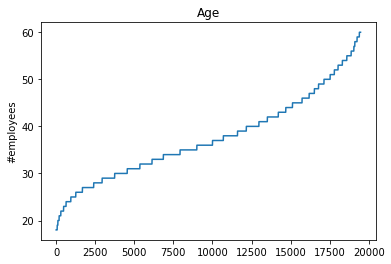

In [29]:
plot = df['Age'].sort_values().plot(use_index=False)
plot.set_title('Age')
plot.set_ylabel('#employees')

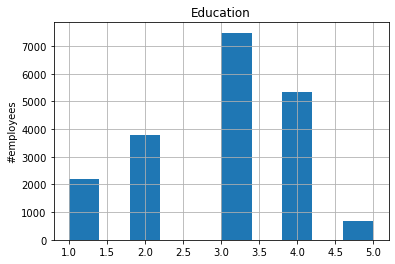

In [30]:
hist = df['Education'].hist()
hist.set_title('Education')
hist.set_ylabel('#employees');

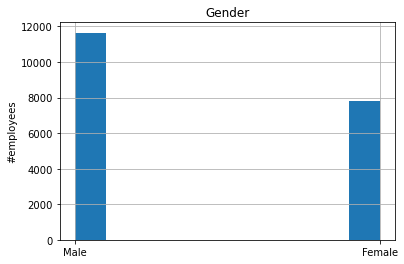

In [31]:
hist = df['Gender'].hist()
hist.set_title('Gender')
hist.set_ylabel('#employees');

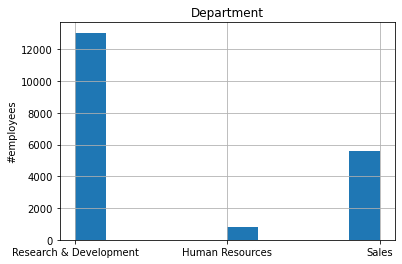

In [25]:
hist = df['Department'].hist()
hist.set_title('Department')
hist.set_ylabel('#employees');

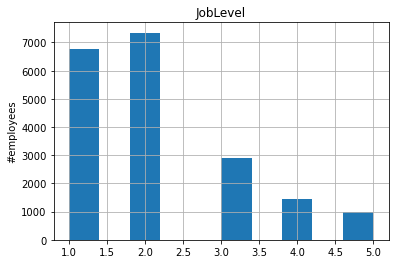

In [32]:
hist = df['JobLevel'].hist()
hist.set_title('JobLevel')
hist.set_ylabel('#employees');

Text(0, 0.5, '#employees')

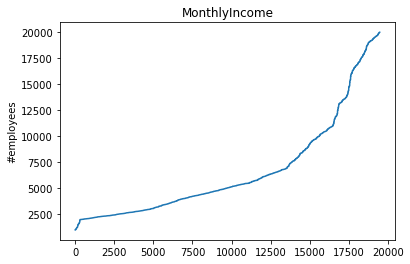

In [28]:
plot = df['MonthlyIncome'].sort_values().plot(use_index=False)
plot.set_title('MonthlyIncome')
plot.set_ylabel('#employees')

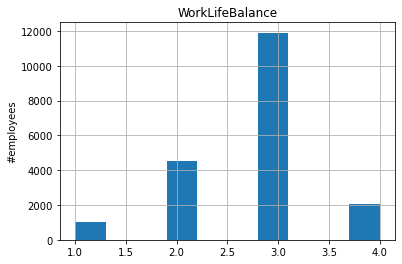

In [33]:
hist = df['WorkLifeBalance'].hist()
hist.set_title('WorkLifeBalance')
hist.set_ylabel('#employees');

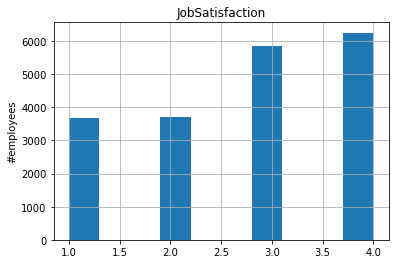

In [34]:
hist = df['JobSatisfaction'].hist()
hist.set_title('JobSatisfaction')
hist.set_ylabel('#employees');

### Loading the final dataset
In the next sections, some operations will be done on the dataset:
- preprocessing;
- adding bias.

This final dataset has been stored into `Datasets/IBM_Job_satisfaction_final.xlsm`. So, instead of doing the next operations, it is enough to load the final dataset, as follows:

In [79]:
df = pd.read_excel('Datasets/IBM_Job_satisfaction_final.xlsm')

## PREPROCESSING
Several preprocessing activities must be carried out before building our model.

*Note: the next operations are not needed if the dataset `Datasets/IBM_Job_satisfaction_final.xlsm` has been loaded*. 

### Dealing with non-numerical features
We map the non-numerical features, i.e. `Department` and `Gender,` into numerical values.

**`Department`** In performing this mapping, the values are ordered in an ascending order with respect to the typical salary in a company: ordering 'Human Resources' - 'Research & Development' - 'Sales'

In [40]:
# Map `Department` into numerical values.
dept_dict = {d:i for i,d in enumerate(df['Department'].unique()[[1, 0, 2]])}
dept_dict_inv = {i:d for d,i in dept_dict.items()}
dept_dict

{'Human Resources': 0, 'Research & Development': 1, 'Sales': 2}

In [41]:
# Perform the mapping for `Department`
df['Department'] = df['Department'].map(dept_dict)

**`Gender`**

In [42]:
# Map `Gender` into numerical values
gender_dict = {g:i for i,g in enumerate(df['Gender'].unique()[[1,0]])}
gender_dict_inv = {i:g for g,i in dept_dict.items()}
gender_dict

{'Female': 0, 'Male': 1}

In [43]:
# Perform the mapping for `Gender`
df['Gender'] = df['Gender'].map(gender_dict)

### Dealing with continuous features
We discretize the continuous features, i.e. `Age` and `MonthlyIncome`. We discretize each feature into three balanced levels. With "balanced" levels we mean that the levels have almost the same number of employees.

**`Age`** First of all, let's do that for `Age`. The three balanced levels are the following: from the min (i.e. $18$) to the $0.33$ quantile; from the $0.33$ quantile to the $0.66$ quantile; from the $0.66$ quantile to the max (i.e. $60$). 

In [44]:
# Computing the levels for dividing `Age` into three balanced intervals
min_age = df['Age'].min()  # 18
max_age = df['Age'].max()  # 60

# 0.33 quantile and 0.66 quantile
q1_age, q2_age = df['Age'].quantile([0.3333,0.6666]).astype(int).values
print(f'0.33 quantile: {q1_age}\t0.66 quantile: {q2_age}')
print()


print(f'The three levels for `Age` are the following:\n\t{min_age}-{q1_age}\n\t{q1_age}-{q2_age}\n\t{q2_age}-{max_age}')

0.33 quantile: 33	0.66 quantile: 41

The three levels for `Age` are the following:
	18-33
	33-41
	41-60


In [45]:
print('Number of employees in the three levels:', end=' ')
(df['Age']<=q1_age).sum(), (np.logical_and(df['Age']>q1_age,df['Age']<=q2_age)).sum(), (df['Age']>q2_age).sum()

Number of employees in the three levels: 

(6856, 6655, 5967)

In [46]:
# Auxiliary function which takes in input an age and returns the string-encoded interval in which the given age belongs.
# Example: age=36 -> level '33-41'
def transform_age(age):
    if age<=q1_age:
        return f'{min_age}-{q1_age}'
    elif age>q1_age and age<=q2_age:
        return f'{q1_age}-{q2_age}'
    elif age>q2_age:
        return f'{q2_age}-{max_age}'
    
# Apply the function on each value
df['Age'] = df['Age'].map(transform_age)

In [47]:
print('Three levels of `Age`:', sorted(list(df['Age'].unique())))

Three levels of `Age`: ['18-33', '33-41', '41-60']


In [48]:
# Now we map the three string-encoded levels into numbers
age_dict = {a:i for i,a in enumerate(sorted(df['Age'].unique()))}
age_dict_inv = {i:a for a,i in age_dict.items()}
age_dict

{'18-33': 0, '33-41': 1, '41-60': 2}

In [49]:
# Apply the mapping
df['Age'] = df['Age'].map(age_dict)

In [50]:
print('Three levels of `Age`:', sorted(list(df['Age'].unique())))

Three levels of `Age`: [0, 1, 2]


**`MonthlyIncome`** Let's now do that same thing for `MonthlyIncome`. The min value is $1009$, while the max is $19999$.

In [51]:
# Computing the levels for dividing `MonthlyIncome` into three balanced intervals
min_inc = df['MonthlyIncome'].min()  # 1009
max_inc = df['MonthlyIncome'].max()  # 19999


q1_inc, q2_inc = df['MonthlyIncome'].quantile([0.3333,0.6666]).astype(int).values
print(f'0.33 quantile: {q1_inc}\t0.66 quantile: {q2_inc}')
print()

print(f'The three levels for `Age` are the following:\n\t{min_inc}-{q1_inc}\n\t{q1_inc}-{q2_inc}\n\t{q2_inc}-{max_inc}')

0.33 quantile: 3812	0.66 quantile: 6632

The three levels for `Age` are the following:
	1009-3812
	3812-6632
	6632-19999


In [52]:
print('Number of employees in the three levels:', end=' ')
(df['MonthlyIncome']<=q1_inc).sum(), (np.logical_and(df['MonthlyIncome']>q1_inc,df['MonthlyIncome']<=q2_inc)).sum(), (df['MonthlyIncome']>q2_inc).sum()

Number of employees in the three levels: 

(6499, 6496, 6483)

In [53]:
# Auxiliary function which takes in input an income and returns the string-encoded interval in which the given income
# belongs.
# Example: income=2700 -> level '1009-3812'
def transform_income(income):
    if income<=q1_inc:
        return f'{min_inc}-{q1_inc}'
    elif income>q1_inc and income<=q2_inc:
        return f'{q1_inc}-{q2_inc}'
    elif income>q2_inc:
        return f'{q2_inc}-{max_inc}'
    
# Apply the function on each value
df['MonthlyIncome'] = df['MonthlyIncome'].map(transform_income)

In [54]:
print('Three levels of `MonthlyIncome`:', sorted(list(df['MonthlyIncome'].unique())))

Three levels of `MonthlyIncome`: ['1009-3812', '3812-6632', '6632-19999']


In [55]:
# Now we map the three levels into numbers
income_dict = {inc:i for i,inc in enumerate(sorted(df['MonthlyIncome'].unique(), key=lambda inc: int(inc.split('-')[0])))}
income_dict_inv = {inc:a for a,inc in income_dict.items()}
income_dict

{'1009-3812': 0, '3812-6632': 1, '6632-19999': 2}

In [56]:
# Apply the mapping
df['MonthlyIncome'] = df['MonthlyIncome'].map(income_dict)

In [57]:
print('Three levels of `MonthlyIncome`:', sorted(list(df['MonthlyIncome'].unique())))

Three levels of `MonthlyIncome`: [0, 1, 2]


### Reducing the number of levels
We take the already discretized variables, i.e. `Education`, `JobLevel`, `WorkLifeBalance`, `JobSatisfaction`, and we reduce the number of levels into three balanced levels.

**`Education`**: levels $1, 2, ..., 5$. We reduce that into three balanced levels $0, 1, 2$.

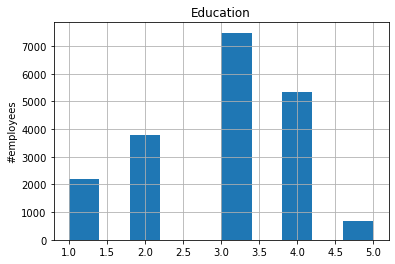

In [58]:
hist = df['Education'].hist()
hist.set_title('Education')
hist.set_ylabel('#employees');

- We aggregate the first two levels into the level $0$.
- We keep alone the third level, as level $1$.
- We aggregate the last two levels into the level $2$.

In [59]:
print('Number of employees in the three levels:', end=' ')
(df['Education']<=2).sum(), (df['Education']==3).sum(), (df['Education']>3).sum()

Number of employees in the three levels: 

(5975, 7479, 6024)

In [60]:
# Auxiliary function which takes in input an education level `e` and returns the new level.
def transform_education(e):
    if e>=1 and e<=2:
        return 0
    elif e==3:
        return 1
    else: 
        return 2

# Apply the function on each value
df['Education'] = df['Education'].map(transform_education)

In [62]:
print('Three levels of `Education`:', sorted(list(df['Education'].unique())))

Three levels of `Education`: [0, 1, 2]


**`JobLevel`**: levels $1,2,...,5$. We reduce that into three balanced levels $0,1,2$.

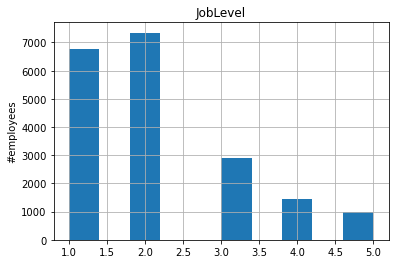

In [63]:
hist = df['JobLevel'].hist()
hist.set_title('JobLevel')
hist.set_ylabel('#employees');

- We keep alone the first level, as level $0$.
- We keep alone the second level, as level $1$.
- We aggregate the last three levels into the level $2$.

In [64]:
print('Number of employees in the three levels:', end=' ')
(df['JobLevel']==1).sum(), (df['JobLevel']==2).sum(), (df['JobLevel']>2).sum()

Number of employees in the three levels: 

(6766, 7347, 5365)

In [65]:
# Auxiliary function which takes in input a job level `l` and returns the new level.
def transform_jobLevel(l):
    if l==1:
        return 0
    elif l==2:
        return 1
    else: 
        return 2

# Apply the function on each value
df['JobLevel'] = df['JobLevel'].map(transform_jobLevel)

In [66]:
print('Three levels of `JobLevel`:', sorted(list(df['JobLevel'].unique())))

Three levels of `JobLevel`: [0, 1, 2]


**`WorkLifeBalance`**: levels $1,2,3,4$. We reduce that into three levels $0,1,2$.

We simply:
- aggregate the first two levels into the same level $0$;
- aggregate the last two levels into the same level $1$.

In [67]:
# Auxiliary function which takes in input a work-life balance level `l` and returns the new level.
def transform_workLifeBalance(b):
    if b>=1 and b<=2:
        return 0
    elif b>=3 and b<=4:
        return 1

# Apply the function on each value
df['WorkLifeBalance'] = df['WorkLifeBalance'].map(transform_workLifeBalance)

In [68]:
print('Three levels of `WorkLifeBalance`:', sorted(list(df['WorkLifeBalance'].unique())))

Three levels of `WorkLifeBalance`: [0, 1]


**`JobSatisfaction`**: levels $1,2,3,4$. We reduce that into three levels $0,1,2$.

We simply:
- aggregate the first two levels into the same level $0$;
- aggregate the last two levels into the same level $1$.

In [69]:
# Auxiliary function which takes in input a job satisfaction level `l` and returns the new level.
def transform_jobSatisfaction(s):
    if s>=1 and s<=2:
        return 0
    elif s>=3 and s<=4:
        return 1

# Apply the function on each value
df['JobSatisfaction'] = df['JobSatisfaction'].map(transform_jobSatisfaction)

In [70]:
print('Three levels of `JobSatisfaction`:', sorted(list(df['JobSatisfaction'].unique())))

Three levels of `JobSatisfaction`: [0, 1]


## ANALYSIS
Eight discretized and balanced features.

In [36]:
df.describe()

,Age,Department,Education,Gender,JobLevel,MonthlyIncome,WorkLifeBalance,JobSatisfaction
count,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000
mean,0.954359,1.246021,1.002516,0.597854,0.928073,0.999179,0.716295,0.620700
std,0.810113,0.518838,0.784891,0.490344,0.785916,0.816412,0.450807,0.485225
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000


Let's explore the relationships between them.

### Heatmap
*Reminder about correlation: correlation is a  real number in $[0,1]$, computed on a pair of variables $X_i$-$X_j$, measuring the linear relation between them.*
- *If the value is high positive, then there is a strong positive linear relation: the higher $X_i$, the higher $X_j$*
- *If the value is close to $0$, then weak linear relation*
- *If the value is high negative, then there is a strong negative linear relation: the higher $X_i$, the lower $X_j$*

<AxesSubplot:>

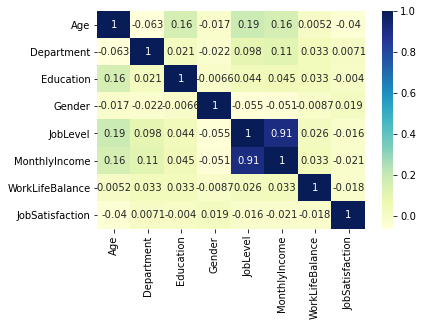

In [70]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)

- Strong correlation between `JobLevel` and `MonthlyIncome`.
- Correlation between `Age`-`JobLevel` and `Age`-`Education` (since there is the correlation `Age`-`JobLevel`, there is also the correlation `Age`-`MonthlyIncome`).
- Correlation (even if weaker) between `Department` and `MonthlyIncome`.
- Between all the remaining features, no relationship. No relationships `Gender`-`JobLevel`, `Education`-`JobLevel`, `MonthlyIncome`-`JobSatisfaction`, `WorkLifeBalance`-`JobSatisfaction`, ... . Quite unrealistic and not suitable for our task.

### Pairplot

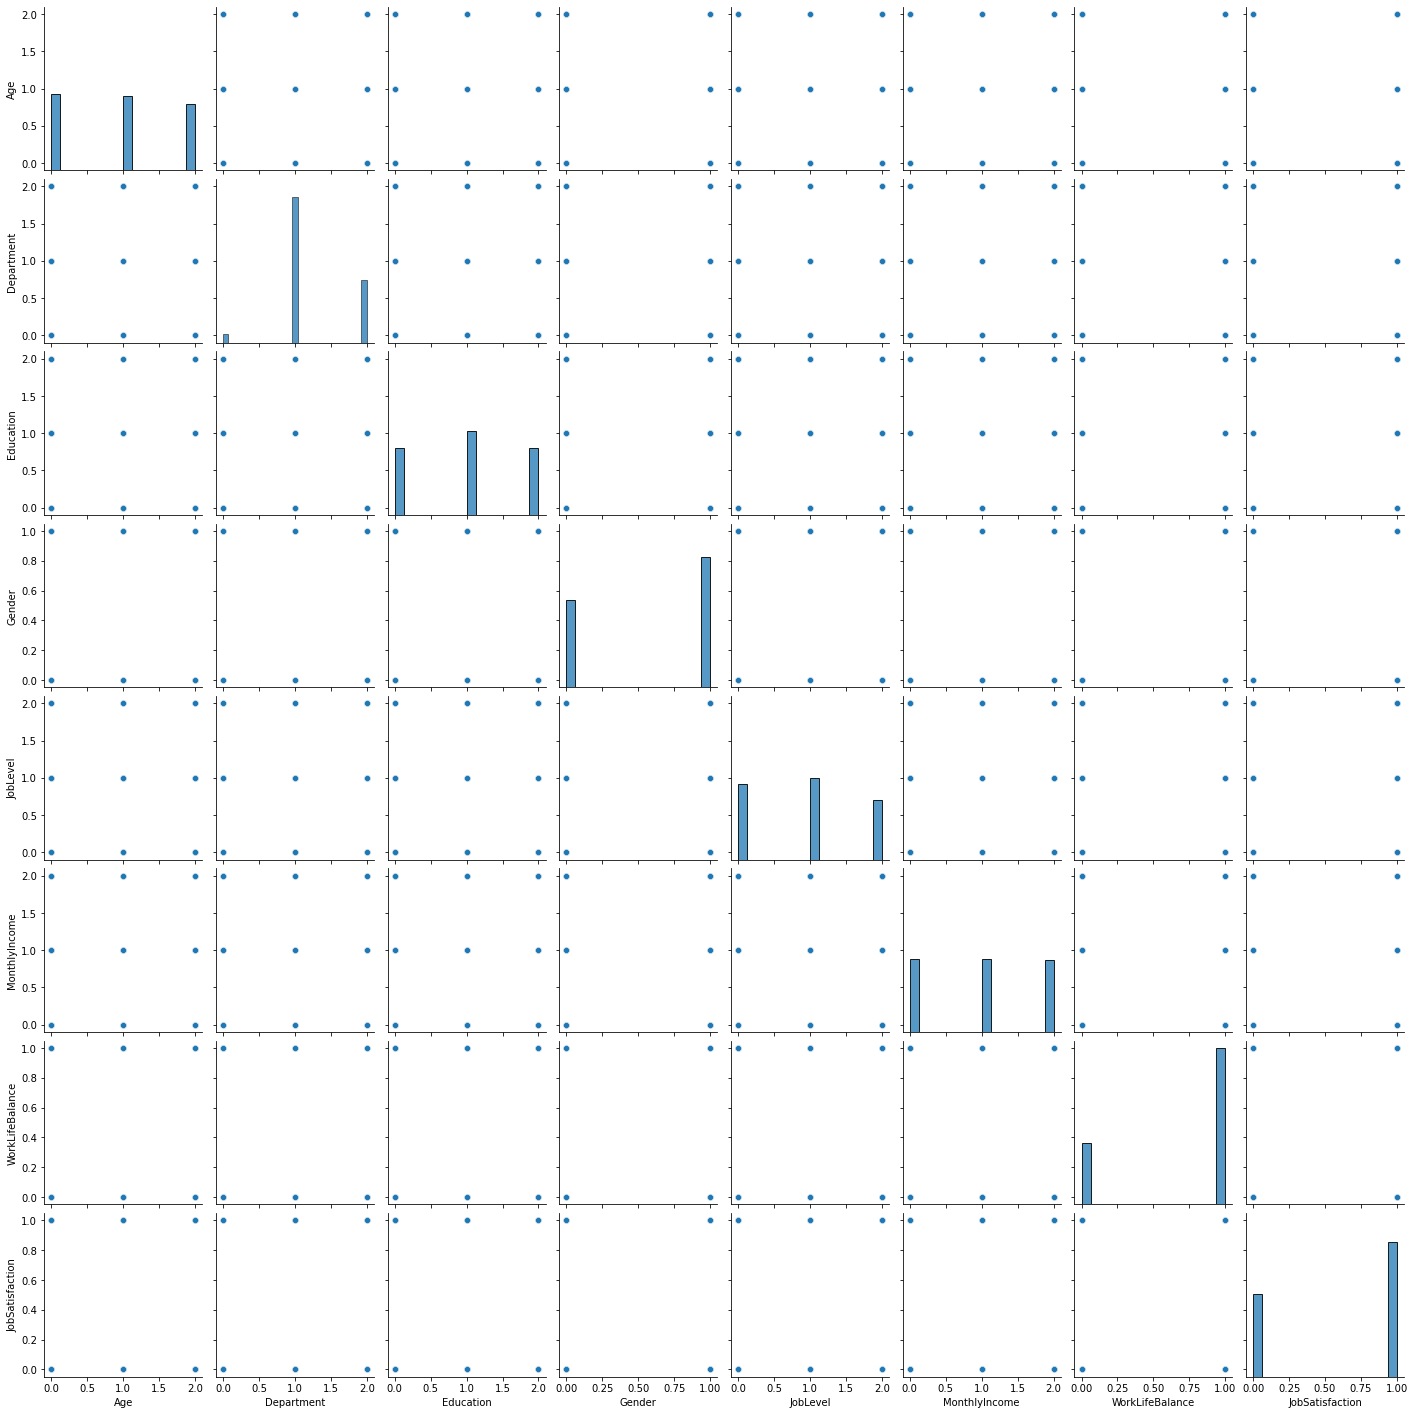

In [71]:
sns.pairplot(df);

The variables are too discretized for seeing any sensible pattern... Let's try with boxplots.

### Boxplots
Apart from `JobLevel`-`MonthlyIncome`, `Age`-`JobLevel`, `Age`-`Education` and `Department`-`MonthlyIncome`, no other relationships.

Let's visualize the relations between features.

Text(0.5, 1.0, 'Relationship JobLevel-MonthlyIncome')

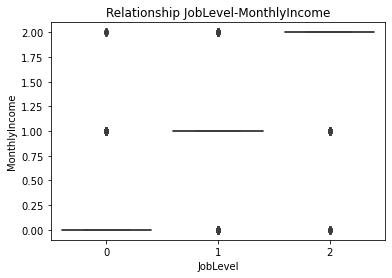

In [72]:
sns.boxplot(x='JobLevel', y='MonthlyIncome', data=df).set_title('Relationship JobLevel-MonthlyIncome')

Text(0.5, 1.0, 'Relationship Age-JobLevel')

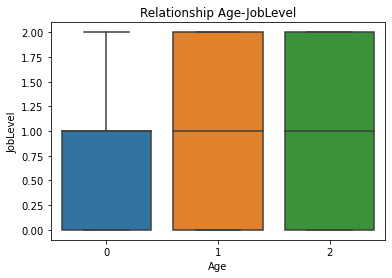

In [73]:
sns.boxplot(x='Age', y='JobLevel', data=df).set_title('Relationship Age-JobLevel')

Text(0.5, 1.0, 'Relationship Age-Education')

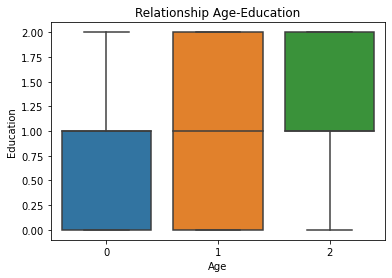

In [74]:
sns.boxplot(x='Age', y='Education', data=df).set_title('Relationship Age-Education')

Text(0.5, 1.0, 'Relationship Department-MonthlyIncome')

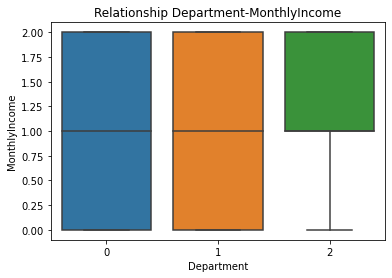

In [75]:
sns.boxplot(x='Department', y='MonthlyIncome', data=df).set_title('Relationship Department-MonthlyIncome')

Apart from these, no other relationships between features.

Text(0.5, 1.0, 'Relationship MonthlyIncome-JobSatisfaction')

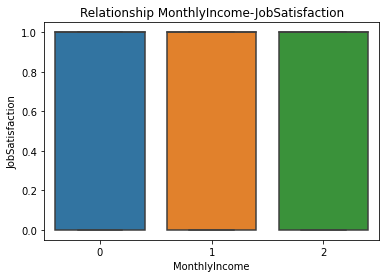

In [76]:
sns.boxplot(x='MonthlyIncome', y='JobSatisfaction', data=df).set_title('Relationship MonthlyIncome-JobSatisfaction')

Text(0.5, 1.0, 'Relationship Gender-JobLevel')

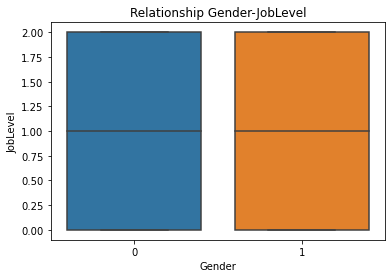

In [77]:
sns.boxplot(x='Gender', y='JobLevel', data=df).set_title('Relationship Gender-JobLevel')

## ADDING BIAS
As it has just been shown, there are only few relationships in our dataset. Only relationships `JobLevel`-`MonthlyIncome`, `Age`-`JobLevel`, `Age`-`Education` and `Department`-`MonthlyIncome`.

This is quite unrealistic, and it is not suitable for our purposes. Therefore, we slightly modify the dataset, by adding some bias into it. 

*Note: the next operations are not needed if the dataset `Datasets/IBM_Job_satisfaction_final.xlsm` has been loaded*. 

### Utility function for injecting bias

In [78]:
from utils import add_bias
help(add_bias)

Help on function add_bias in module utils:

add_bias(data, antecedent, consequent, positive=True, amount=0.2)
    Adds some bias in the given dataset, for injecting a certain relationship.
    
    The relationship of interest is the relationship between the variables `antecedent` and `consequent`. In particular, the
    relationship of interest is `antecedent`->`consequent`.
    Intuitively, this relationship is enforced by slightly modifying some values of `consequent` s.t. a bigger correlation 
    between the two variabless emerges. 
    
    Parameters
    ----------
    data : pd.DataFrame
        Dataset into which injecting the bias
    antecedent : str
        Antecedent feature
    consequent : str
        Consequent feature
    positive : bool, optional
        Positive or negative influence of the antecedent variable on the consequent variable, by default True.
        Positive influence means positive correlation: the bigger `antecedent`, the bigger `consequent`.
        N

### `Gender`-`JobLevel`

Positive influence.

In [49]:
df = add_bias(data=df, evidence='Gender', variable='JobLevel', amount=0.45)

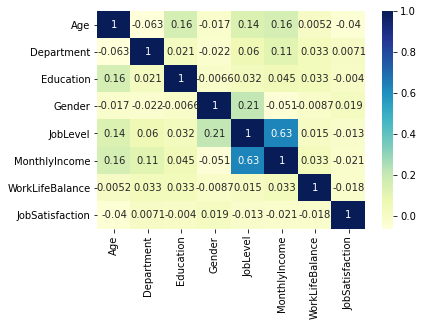

In [50]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True);

### `Education`-`JobLevel`
Positive influence.

In [58]:
df = add_bias(data=df, evidence='Education', variable='JobLevel', amount=0.3)

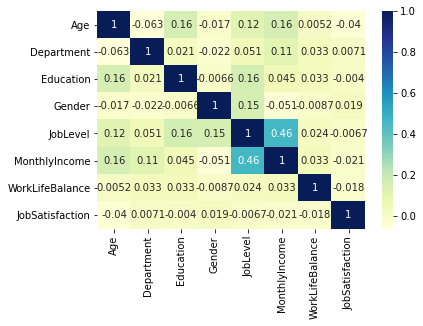

In [59]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True);

### `JobLevel`-`WorkLifeBalance`
Negative influence

In [61]:
df = add_bias(data=df, evidence='JobLevel', variable='WorkLifeBalance', positive=False, amount=0.4)

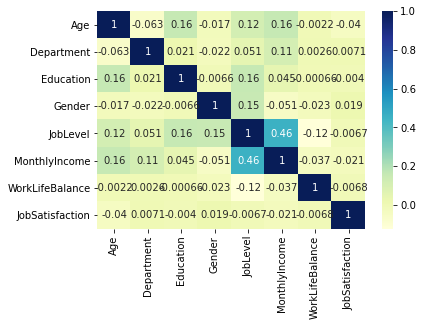

In [62]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True);

### `Department`-`WorkLifeBalance`
Negative influence

In [66]:
dept_dict

{'Human Resources': 0, 'Research & Development': 1, 'Sales': 2}

In [67]:
df = add_bias(data=df, evidence='Department', variable='WorkLifeBalance', positive=False, amount=0.4)

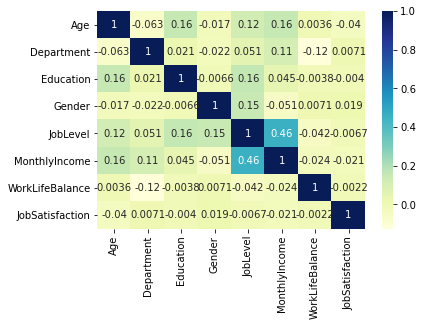

In [68]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True);

### `MonthlyIncome`-`JobSatisfaction`
Positive influence.

In [70]:
df = add_bias(data=df, evidence='MonthlyIncome', variable='JobSatisfaction', positive=True, amount=0.3)

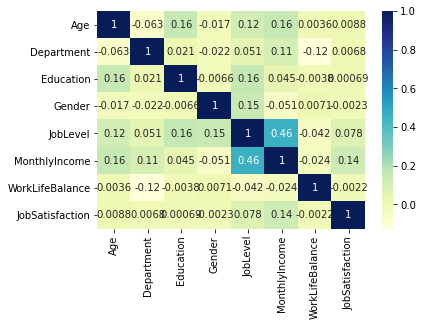

In [71]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True);

### `JobLevel`-`JobSatisfaction`
Positive influence.

In [89]:
df = add_bias(data=df, evidence='JobLevel', variable='JobSatisfaction', positive=True, amount=0.3)

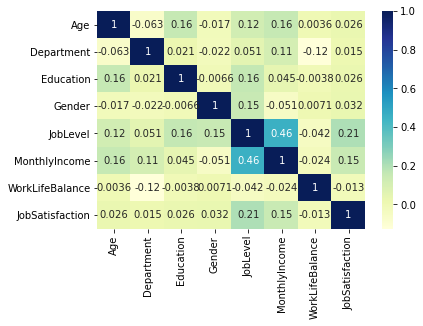

In [90]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True);

### `WorkLifeBalance`-`WobSatisfaction`
Positive influence.

In [118]:
df = add_bias(data=df, evidence='WorkLifeBalance', variable='JobSatisfaction', positive=True, amount=0.19)

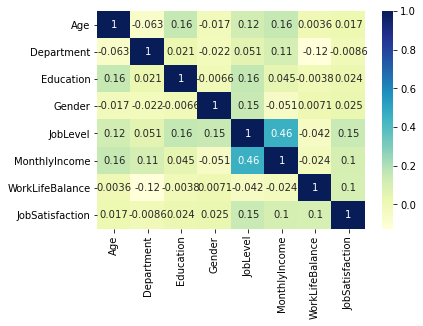

In [119]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True);

### Saving the new dataset
To do only the first time.

In [122]:
df.to_excel('Datasets/IBM_Job_satisfaction_final.xlsm')

### Further analysis of the new dataset

In [124]:
df.describe()

,Age,Department,Education,Gender,JobLevel,MonthlyIncome,WorkLifeBalance,JobSatisfaction
count,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000,19478.000000
mean,0.954359,1.246021,1.002516,0.597854,0.780830,0.999179,0.767481,0.428791
std,0.810113,0.518838,0.784891,0.490344,0.773375,0.816412,0.422449,0.494916
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000
max,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000


Now we can appreciate many other relationships in our dataset.

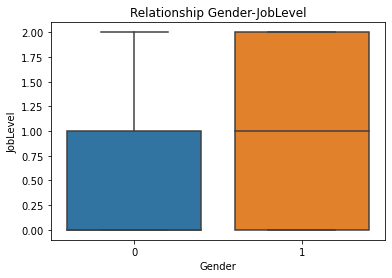

In [80]:
sns.boxplot(x='Gender', y='JobLevel', data=df).set_title('Relationship Gender-JobLevel');

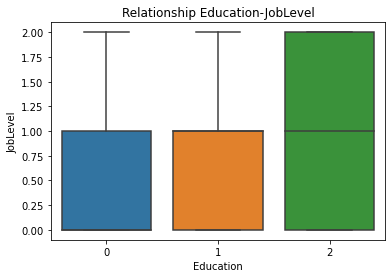

In [81]:
sns.boxplot(x='Education', y='JobLevel', data=df).set_title('Relationship Education-JobLevel');

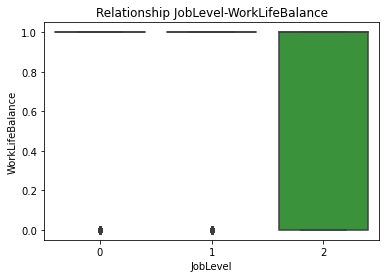

In [82]:
sns.boxplot(x='JobLevel', y='WorkLifeBalance', data=df).set_title('Relationship JobLevel-WorkLifeBalance');

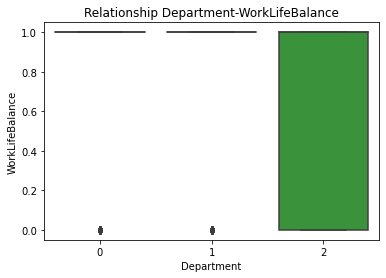

In [83]:
sns.boxplot(x='Department', y='WorkLifeBalance', data=df).set_title('Relationship Department-WorkLifeBalance');

## STRUCTURE OF THE BAYESIAN NETWORK
Based on the already-present relationships and on the added relationships, the following is the defined Bayesian Network.
<img src="Images/BayesianNetwork.png" width="600">

## TRAINING THE BAYESIAN NETWORK
In this section, the training of Bayesian Networks is described. Training a Bayesian Network means learning the values of the parameters in the network, namely the probabilities in the Conditional Probability Distributions (i.e. CPDs). This process is of course driven by the data: we are learning the parameters/probabilities from the given data.

The two main algorithms for training a Bayesian Network are: Maximum Likelihood Estimation (i.e. MLE) and Bayesian Estimation. We will see and apply the first one: MLE.

In this section, the idea of how MLE works is explained. Moreover, an user-defined implementation of MLE is shown, carrying out also some examples on our dataset.

However, this user-defined implementation is not recquired, since the `pgmpy` library is able to train the model by itself. So, later we will simply call a `pgmpy` method for performing the training process.

### MLE: in short
Let $D$ be our dataset and $\theta$ be the parameters of the model, where each $\theta_i$ represents the CPD associated with the variable $X_i$ of the network. The likelihood function represents the chance that the parameters have values $\theta$ given that the observed dataset is $D$: it is the global likelihood of the whole model. It is defined as $$L(\theta|D) = \prod_i l_i(\theta_i|D)$$. 

Each $l_i(\theta_i|D)$ is the local likelihood of the variable $X_i$, representing the chance that the CPD of $X_i$ is $\theta_i$. It is defined as: $$l_i(\theta_i|D) = \prod_m P(x_i=m|Parents(X_i)=m,\theta_i)$$.

The objective of MLE is to maximize the function $L(\theta|D)$: $$\theta^* = argmax \quad L(\theta|D)$$.

For computational reasons, this is typically carried out by considering the negative log-likelihood and by minimizing it.

### MLE: in practice
In practice, the MLE works in the following way. Let's suppose that we want to compute the CPD of the variable $X$ with respect to the variables $X_1,...,X_n$, i.e. the parents. ($X$ could have no parents: in this case the prior distribution of $X$ is computed).

Computing the CPD consists in computing the probability of $X=x$ conditioned to $X_1=x_1,...,X_n=x_n$, for each possible value $x$ of $X$ and for each possible combination of values $x_1,...,x_n$ of $X_1,...,X_n$ (if each $X_i$ has $n_i$ possible different values, the number of different possible combinations is $\prod_i n_i$).

To sum up, the objective is to compute the probability $P(X=x|X_1=x_1,...,X_n=x_n)$ for each value $x$ and for each combination $x_1,...,x_n$.

This probability $P(X=x|X_1=x_1,...,X_n=x_n)$ is simply computed in the following way.
- The number of instances in the training set s.t. $X_1=x_1,...,X_n=x_n$ is count. Let $M$ be this number.
- The number of instancees in the training set s.t. $X=x$  and $X_1=x_1,...,X_n=x_n$ is count. Let $K$ be this number. For sure, we have that $K\leq M$.
- Finally, we have that $P(X=x|X_1=x_1,...,X_n=x_n) = K/M$.

Basically, $P(X=x|X_1=x_1,...,X_n=x_n)$ is simply computed as the portion of instances with $X=x$ among all instances with $X_1=x_1,...,X_n=x_n$. It is simply a conditioned relative frequency.

### MLE: results
With MLE, the CPD pf each variable $X_i$ is computed, which is basically a table.

If $X_i$ has no parents, the table is simply the prior distribution. Just one row. <img src="Images/CPD Age.png" width="300">

If $X_i$ has some parents, the table is the CPD. Each row is a probability distribution of the variable given the corresponding combination of values for its evidences/parent nodes. <img src="Images/CPD JobLevel.png" width="300">

### MLE: user-defined implementation
The MLE estimation has been implemented in an utility function.

In [85]:
from utils import compute_cpd

In [86]:
help(compute_cpd)

Help on function compute_cpd in module utils:

compute_cpd(data, variable, evidences=None)
    Computes the CPD of `variable` with respect to the `evidences`, using the given dataset.
    
    The list of evidence variables in `evidences` could be empty: in such case, the prior distribution of `variable` is 
    computed.
    
    Parameters
    ----------
    data : pd.DataFrame
        Dataset
    variable : str
        Variable on which the CPD is computed
    evidences : list of str, optional
        List of evidence variables, by default None
    
    Returns
    -------
    cpd: pd.DataFrame
        Desired CPD
    
    Notes
    -------
    In the comments in the code, we denote `variable` as X, with a specific possible value x. And we denote `evidences` as 
    X1,...,Xk, with specific possible values x1, ..., xk.



### Computing the CPD: some examples

**CPD of `Age`**. Prior distribution.

In [87]:
compute_cpd(data=df, variable='Age')

Age,0,1,2
Evidences,,,
,0.351987,0.341668,0.306346


**CPD of `JobLevel`**. Prior distribution.

In [7]:
compute_cpd(data=df, variable='JobLevel')

JobLevel,0,1,2
Evidences,,,
,0.432642,0.353886,0.213472


Let's now put the evidence (i.e. parent node) `Age`.

In [9]:
compute_cpd(data=df, variable='JobLevel', evidences=['Age'])

JobLevel,0,1,2
Evidences,,,
Age==0,0.503209,0.333139,0.163652
Age==1,0.409617,0.370098,0.220285
Age==2,0.377241,0.359645,0.263114


As it can be noticed, a bigger `Age` increases the probability of having a bigger `JobLevel`.

Let's now put also the evidence `Education`.

In [10]:
compute_cpd(data=df, variable='JobLevel', evidences=['Age','Education'])

JobLevel,0,1,2
Evidences,,,
Age==0 Education==0,0.550719,0.319833,0.129447
Age==0 Education==1,0.529866,0.322909,0.147224
Age==0 Education==2,0.355994,0.380117,0.263889
Age==1 Education==0,0.492769,0.363685,0.143546
Age==1 Education==1,0.436577,0.368375,0.195048
Age==1 Education==2,0.322204,0.376508,0.301287
Age==2 Education==0,0.420873,0.364256,0.214870
Age==2 Education==1,0.404118,0.364221,0.231660
Age==2 Education==2,0.318894,0.351613,0.329493


Also a bigger `Education` increases the probability of having a bigger `JobLevel`.

Finally, let's put also the `Gender` parent node.

In [11]:
compute_cpd(data=df, variable='JobLevel', evidences=['Age','Education', 'Gender'])

JobLevel,0,1,2
Evidences,,,
Age==0 Education==0 Gender==0,0.662626,0.257576,0.079798
Age==0 Education==0 Gender==1,0.483656,0.357143,0.159201
Age==0 Education==1 Gender==0,0.652372,0.243613,0.104015
Age==0 Education==1 Gender==1,0.453143,0.372571,0.174286
Age==0 Education==2 Gender==0,0.403333,0.383333,0.213333
Age==0 Education==2 Gender==1,0.319010,0.377604,0.303385
Age==1 Education==0 Gender==0,0.616310,0.286096,0.097594
Age==1 Education==0 Gender==1,0.410188,0.415550,0.174263
Age==1 Education==1 Gender==0,0.518478,0.347826,0.133696


As it can be noticed, also being a male (i.e. `Gender`$=1$) increases the probability of having a bigger `JobLevel`. 

**CPD of `WorkLifeBalance`**. Let's now inspect the CPD of `WorkLifeBalance`. First of all, prior distribution.

In [16]:
compute_cpd(data=df, variable='WorkLifeBalance')

WorkLifeBalance,0,1
Evidences,,
,0.232519,0.767481


Let's add the evidence `JobLevel`.

In [17]:
compute_cpd(data=df, variable='WorkLifeBalance', evidences=['JobLevel'])

WorkLifeBalance,0,1
Evidences,,
JobLevel==0,0.217040,0.782960
JobLevel==1,0.231249,0.768751
JobLevel==2,0.265993,0.734007


A bigger `JobLevel` decreases the probability of having a balanced work-life management.

Finally, let's put also the evidence `Department`.

In [18]:
compute_cpd(data=df, variable='WorkLifeBalance', evidences=['JobLevel', 'Department'])

WorkLifeBalance,0,1
Evidences,,
JobLevel==0 Department==0,0.092838,0.907162
JobLevel==0 Department==1,0.194170,0.805830
JobLevel==0 Department==2,0.299908,0.700092
JobLevel==1 Department==0,0.102190,0.897810
JobLevel==1 Department==1,0.203232,0.796768
JobLevel==1 Department==2,0.308278,0.691722
JobLevel==2 Department==0,0.176829,0.823171
JobLevel==2 Department==1,0.239805,0.760195
JobLevel==2 Department==2,0.330053,0.669947


Also working in an higher `Department` decreases the probability of having a good `WorkLifeBalance`.

**CPD of `JobSatisfaction`**. Let's now inspect the CPD of `JobSatisfaction`. First of all, prior distribution.

In [12]:
compute_cpd(data=df, variable='JobSatisfaction')

JobSatisfaction,0,1
Evidences,,
,0.571209,0.428791


Then, we add the evidence `JobLevel`.

In [13]:
compute_cpd(data=df, variable='JobSatisfaction', evidences=['JobLevel'])

JobSatisfaction,0,1
Evidences,,
JobLevel==0,0.634627,0.365373
JobLevel==1,0.576962,0.423038
JobLevel==2,0.433141,0.566859


Having an higher `JobLevel` increases the probability of being satisfied about the job.

Let's put also the evidence `MonthlyIncome`.

In [14]:
compute_cpd(data=df, variable='JobSatisfaction', evidences=['JobLevel', 'MonthlyIncome'])

JobSatisfaction,0,1
Evidences,,
JobLevel==0 MonthlyIncome==0,0.643902,0.356098
JobLevel==0 MonthlyIncome==1,0.654168,0.345832
JobLevel==0 MonthlyIncome==2,0.548018,0.451982
JobLevel==1 MonthlyIncome==0,0.595099,0.404901
JobLevel==1 MonthlyIncome==1,0.598390,0.401610
JobLevel==1 MonthlyIncome==2,0.542473,0.457527
JobLevel==2 MonthlyIncome==0,0.488959,0.511041
JobLevel==2 MonthlyIncome==1,0.421875,0.578125
JobLevel==2 MonthlyIncome==2,0.430955,0.569045


Also a bigger `MonthlyIncome` increases the `JobSatisfaction`.

Finally, let's put also the evidence `WorkLifeBalance`.

In [15]:
compute_cpd(data=df, variable='JobSatisfaction', evidences=['JobLevel', 'MonthlyIncome', 'WorkLifeBalance'])

JobSatisfaction,0,1
Evidences,,
JobLevel==0 MonthlyIncome==0 WorkLifeBalance==0,0.752711,0.247289
JobLevel==0 MonthlyIncome==0 WorkLifeBalance==1,0.614248,0.385752
JobLevel==0 MonthlyIncome==1 WorkLifeBalance==0,0.752252,0.247748
JobLevel==0 MonthlyIncome==1 WorkLifeBalance==1,0.626023,0.373977
JobLevel==0 MonthlyIncome==2 WorkLifeBalance==0,0.609959,0.390041
JobLevel==0 MonthlyIncome==2 WorkLifeBalance==1,0.531320,0.468680
JobLevel==1 MonthlyIncome==0 WorkLifeBalance==0,0.727488,0.272512
JobLevel==1 MonthlyIncome==0 WorkLifeBalance==1,0.556701,0.443299
JobLevel==1 MonthlyIncome==1 WorkLifeBalance==0,0.707612,0.292388


Also having a good `WorkLifeBalance` increases the probability of having a good `JobSatisfaction`.

## DEFINING THE BAYESIAN NETWORK
Let's now create the Bayesian Network, using the `pgmpy` library.

In [92]:
from pgmpy.models import BayesianNetwork

In [93]:
# We create the model by defining the list of edges between the variables
job_satisfaction_model = BayesianNetwork(
    [
        ('Age', 'Education'),
        ('Age', 'JobLevel'),
        ('Education', 'JobLevel'),
        ('Gender', 'JobLevel'),
        ('Department', 'MonthlyIncome'),
        ('JobLevel', 'MonthlyIncome'),
        ('Department', 'WorkLifeBalance'),
        ('JobLevel', 'WorkLifeBalance'),
        ('JobLevel', 'JobSatisfaction'),
        ('MonthlyIncome', 'JobSatisfaction'),
        ('WorkLifeBalance', 'JobSatisfaction'),
    ]
)

### Training

Training the model, namely computing the CPDs. By default, the training performs the MLE technique, as explained before.

In [94]:
job_satisfaction_model.fit(data=df)

Checking the correctness of the model.

In [154]:
job_satisfaction_model.check_model()

True

The computed CPDs are exactly equal to the CPDs computed by the user-defined functionality shown before.

CPD of `Age`

In [24]:
# CPD of Age
print(job_satisfaction_model.get_cpds('Age').get_values().T)
compute_cpd(data=df, variable='Age')

[[0.35198686 0.34166752 0.30634562]]


Age,0,1,2
Evidences,,,
,0.351987,0.341668,0.306346


CPD of `JobLevel`

In [25]:
# CPD of JobLevel
print(job_satisfaction_model.get_cpds('JobLevel').get_values().T)
compute_cpd(data=df, variable='JobLevel', evidences=['Age', 'Education', 'Gender'])

[[0.66262626 0.25757576 0.07979798]
 [0.48365617 0.35714286 0.15920097]
 [0.65237226 0.24361314 0.1040146 ]
 [0.45314286 0.37257143 0.17428571]
 [0.40333333 0.38333333 0.21333333]
 [0.31901042 0.37760417 0.30338542]
 [0.61631016 0.28609626 0.09759358]
 [0.41018767 0.4155496  0.17426273]
 [0.51847826 0.34782609 0.13369565]
 [0.38205499 0.38205499 0.23589001]
 [0.37168142 0.3913471  0.23697148]
 [0.28795099 0.36623553 0.34581348]
 [0.58923077 0.28923077 0.12153846]
 [0.28676471 0.42401961 0.28921569]
 [0.47325103 0.36213992 0.16460905]
 [0.35467255 0.36571008 0.27961737]
 [0.36547619 0.36904762 0.26547619]
 [0.28947368 0.3406015  0.36992481]]


JobLevel,0,1,2
Evidences,,,
Age==0 Education==0 Gender==0,0.662626,0.257576,0.079798
Age==0 Education==0 Gender==1,0.483656,0.357143,0.159201
Age==0 Education==1 Gender==0,0.652372,0.243613,0.104015
Age==0 Education==1 Gender==1,0.453143,0.372571,0.174286
Age==0 Education==2 Gender==0,0.403333,0.383333,0.213333
Age==0 Education==2 Gender==1,0.319010,0.377604,0.303385
Age==1 Education==0 Gender==0,0.616310,0.286096,0.097594
Age==1 Education==0 Gender==1,0.410188,0.415550,0.174263
Age==1 Education==1 Gender==0,0.518478,0.347826,0.133696


## ANALYSIS OF THE BAYESIAN NETWORK
Let's perform some analysis of the model.

### Independences
Let's inspect the independences of each variable, given its parents.

**`Age`**

In [28]:
job_satisfaction_model.local_independencies('Age')

(Age ⟂ Gender, Department)

**`Education`**

In [30]:
job_satisfaction_model.local_independencies('Education')

(Education ⟂ Gender, Department | Age)

**`Gender`**

In [31]:
job_satisfaction_model.local_independencies('Gender')

(Gender ⟂ Age, Education, Department)

**`Department`**

In [32]:
job_satisfaction_model.local_independencies('Department')

(Department ⟂ Gender, Age, JobLevel, Education)

**`JobLevel`**

In [33]:
job_satisfaction_model.local_independencies('JobLevel')

(JobLevel ⟂ Department | Gender, Age, Education)

**`WorkLifeBalance`**

In [35]:
job_satisfaction_model.local_independencies('WorkLifeBalance')

(WorkLifeBalance ⟂ Gender, MonthlyIncome, Age, Education | JobLevel, Department)

**`MonthlyIncome`**

In [34]:
job_satisfaction_model.local_independencies('MonthlyIncome')

(MonthlyIncome ⟂ Gender, WorkLifeBalance, Age, Education | JobLevel, Department)

**`JobSatisfaction`**

In [36]:
job_satisfaction_model.local_independencies('JobSatisfaction')

(JobSatisfaction ⟂ Gender, Age, Education, Department | WorkLifeBalance, MonthlyIncome, JobLevel)

### Flow of influence

In this section, we analyize how the influence of each variable $X$ flows across the network. We can think of the flow of influence of $X$ as the set of variables $X_i$ reached by the influence of $X$. It is important to point out that the influence of $X$ can flow in every direction, not only downward: $X$ can also influence variables which are upward with respect to him.

The flow of influence of $X$ can change depending on if we have some evidences and which variables are these evidences.

If a variable $X_i$ is reached by the flow of influence of $X$, then $X_i$ is dependent from $X$ (given the optional evidences). If $X_i$ is not reached by the flow of influence of $X$, then $X_i$ is independent with respect to $X$ (given the optional evidences, conditional independency).

In this section, we inspect the flow of influence of each variable, without having any evidence.

**`Age`**

In [39]:
# Flow of influence of `Age`
job_satisfaction_model.active_trail_nodes('Age')

{'Age': {'Age',
  'Education',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

*The variables which are not reached by the flow of influence of `Age` are the variables which are independent from `Age` (without having any evidence, absolute independence).*

**`Education`**

In [40]:
# Flow of influence of `Education`
job_satisfaction_model.active_trail_nodes('Education')

{'Education': {'Age',
  'Education',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

*The variables which are not reached by the flow of influence of `Education` are the variables which are independent from `Education` (without having any evidence, absolute independence).*

**`Gender`**

In [41]:
# Flow of influence of `Gender`
job_satisfaction_model.active_trail_nodes('Gender')

{'Gender': {'Gender',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

*The variables which are not reached by the flow of influence of `Gender` are the variables which are independent from `Gender` (without having any evidence, absolute independence).*

**`Department`**

In [42]:
# Flow of influence of `Department`
job_satisfaction_model.active_trail_nodes('Department')

{'Department': {'Department',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

*The variables which are not reached by the flow of influence of `Department` are the variables which are independent from `Department` (without having any evidence, absolute independence).*

**`JobLevel`**

In [44]:
# Flow of influence of `JobLevel`
job_satisfaction_model.active_trail_nodes('JobLevel')

{'JobLevel': {'Age',
  'Education',
  'Gender',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

*The variables which are not reached by the flow of influence of `JobLevel` are the variables which are independent from `JobLevel` (without having any evidence, absolute independence).*

**`WorkLifeBalance`**

In [43]:
# Flow of influence of `WorkLifeBalance`
job_satisfaction_model.active_trail_nodes('WorkLifeBalance')

{'WorkLifeBalance': {'Age',
  'Department',
  'Education',
  'Gender',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

*The variables which are not reached by the flow of influence of `WorkLifeBalance` are the variables which are independent from `WorkLifeBalance` (without having any evidence, absolute independence).*

**`MonthlyIncome`**

In [45]:
# Flow of influence of `MonthlyIncome`
job_satisfaction_model.active_trail_nodes('MonthlyIncome')

{'MonthlyIncome': {'Age',
  'Department',
  'Education',
  'Gender',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

*The variables which are not reached by the flow of influence of `MonthlyIncome` are the variables which are independent from `MonthlyIncome` (without having any evidence, absolute independence).*

**`JobSatisfaction`**

In [46]:
# Flow of influence of `JobSatisfaction`
job_satisfaction_model.active_trail_nodes('JobSatisfaction')

{'JobSatisfaction': {'Age',
  'Department',
  'Education',
  'Gender',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

*The variables which are not reached by the flow of influence of `JobSatisfaction` are the variables which are independent from `JobSatisfaction` (without having any evidence, absolute independence).*

### Breaking the flow of influence
Normally, between two variables for which there exist a path linking them, there is the flow of influence. They influence each other. <img src="Images/NormalFlow.png" width="40">

However, if we add as evidence a node between the two variables and that node is the only passage of the flow of influence between the two variables, then the flow is broken: the two variables don't influence each other anymore  <img src="Images/BreakFlow.png" width="40">

Let's see some examples.

**Breaking the flow of influence between `Age`-`MonthlyIncome`**

Without having any evidence, these two variables influence each other. Indeed, `MonthlyIncome` is in the flow of influence of `Age`.

In [180]:
# Flow of influence of `Age`
job_satisfaction_model.active_trail_nodes('Age')

{'Age': {'Age',
  'Education',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

The influence flows between `Age` and `MonthlyIncome` only passing through `JobLevel`. `JobLevel` is the only passage of the influence between `Age` and `MonthlyIncome`. This means that, if we add `JobLevel` as evidence, the flow of influence between `Age` and `MonthlyIncome` is broken. <img src="Images/BreakInfluence_Age_MonthlyIncome.png" width="400">

In [181]:
# Flow of influence of `Age` with evidence 'JobLevel': `MonthlyIncome` is not influenced anymore by `Age`
job_satisfaction_model.active_trail_nodes('Age', observed='JobLevel')

{'Age': {'Age', 'Education', 'Gender'}}

This exact same reasoning can be applied also if we replace `Age` with `Education`/`Gender` and/or if we replace `MonthlyIncome` with `JobSatisfaction`/`WorkLifeBalance`.

### V-structures
Normally, the influence does not flow between two variables which are the common parents of the same node. <img src="Images/V-structure.png" width="200">
However, if the common child, or a descendent of the common child, is in the evidence, then this opens the flow of the influence between the common parents: this is the V-structure.

Let's see some exaples.

**V-structure `Age`-`Gender`**

If we don't have any evidence, the influence does not flow between these two variables. Indeed, they are independent. However, if we add the evidence `JobLevel` (or any descendant of this variable), then the V-structure activates and it opens the flow of the influence between the common parents.

<img src="Images/VS_Age_Gender.png" width="350">

In [47]:
# Flow of incluence of `Age`, without any evidence. The variable `Gender` is not reached by the influence of 
# `Age`: they are independent.
job_satisfaction_model.active_trail_nodes('Age')

{'Age': {'Age',
  'Education',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

In [48]:
# Flow of incluence of `Age`, with the evidence `JobLevel`: the variable `Gender` now is reached by the flow of influence
job_satisfaction_model.active_trail_nodes('Age', observed='JobLevel')

{'Age': {'Age', 'Education', 'Gender'}}

*It is important to notice that putting the evidence `JobLevel` removes many nodes from the flow of influence of `Age`*

**V-structure `Education`-`Gender`**

The same thing happens also between `Education` and `Gender`. 
- If no evidence $\implies$ the variables are independent.
- If evidence `JobLevel` (or any descendant) $\implies$ the variables influence each other.

<img src="Images/VS_Education_Gender.png" width="350">

In [49]:
# Flow of incluence of `Education`, without any evidence. The variable `Gender` is not reached by the influence of 
# `Education`: they are independent.
job_satisfaction_model.active_trail_nodes('Education')

{'Education': {'Age',
  'Education',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

In [51]:
# Flow of incluence of `Education`, with the evidence `JobLevel`: the variable `Gender` now is reached by the flow of 
# influence
job_satisfaction_model.active_trail_nodes('Education', observed='JobLevel')

{'Education': {'Age', 'Education', 'Gender'}}

*It is important to notice that putting the evidence `JobLevel` removes many nodes from the flow of influence of `Education`*

**V-structure `JobLevel`-`Department`**

The same thing happens also between `JobLevel` and `Department`. 
- If no evidence $\implies$ the variables are independent.
- If evidence `MonthlyIncome` (or any descendant) $\implies$ the variables influence each other.

<img src="Images/VS_JobLevel_Department.png" width="350">

Actualy, the variable `JobLevel`-`Department` have more than one common child. They have two common childs: `MonthlyIncome` and `WorkLifeBalance`. Therefore, we can choose one of these two variables to activate the V-structure (or any descendant of these nodes).

In [52]:
# Flow of incluence of `JobLevel`, without any evidence. The variable `Department` is not reached by the influence of 
# `JobLevel`: they are independent.
job_satisfaction_model.active_trail_nodes('JobLevel')

{'JobLevel': {'Age',
  'Education',
  'Gender',
  'JobLevel',
  'JobSatisfaction',
  'MonthlyIncome',
  'WorkLifeBalance'}}

In [53]:
# Flow of incluence of `JobLevel`, with the evidence `MonthlyIncome`: the variable `Department` now is reached by the flow 
# of influence
job_satisfaction_model.active_trail_nodes('JobLevel', observed='MonthlyIncome')

{'JobLevel': {'Age',
  'Department',
  'Education',
  'Gender',
  'JobLevel',
  'JobSatisfaction',
  'WorkLifeBalance'}}

### Markov blankets
Given a variable $X$, its Markov blanket is the set of nodes consisting of:
- all its parents;
- all its children;
- all the parents of its children.

<img src="Images/Markov_blanket.png" width="200">

The important point is that each variable $X$ is independent from all other variables $X_i$  of the network if the markov blanket is given as evidence, namely if all the variables in the Markov blanket are given as evidence.

Let's see some examples.

**`Age`** <img src="Images/MB_Age.png" width="400">

In [62]:
mb_age = job_satisfaction_model.get_markov_blanket('Age')
mb_age

['Gender', 'JobLevel', 'Education']

In [63]:
# `Age` is independent from all other nodes given its Markov blanket
job_satisfaction_model.active_trail_nodes('Age', observed=mb_age)

{'Age': {'Age'}}

**`Education`** <img src="Images/MB_Education.png" width="400">

In [64]:
mb_education = job_satisfaction_model.get_markov_blanket('Education')
mb_education

['Gender', 'Age', 'JobLevel']

In [65]:
# `Education` is independent from all other nodes given its Markov blanket
job_satisfaction_model.active_trail_nodes('Education', observed=mb_education)

{'Education': {'Education'}}

**`Gender`** <img src="Images/MB_Gender.png" width="400">

In [66]:
mb_gender = job_satisfaction_model.get_markov_blanket('Gender')
mb_gender

['Age', 'JobLevel', 'Education']

In [67]:
# `Gender` is independent from all other nodes given its Markov blanket
job_satisfaction_model.active_trail_nodes('Gender', observed=mb_gender)

{'Gender': {'Gender'}}

**`Department`** <img src="Images/MB_Department.png" width="400">

In [68]:
mb_department = job_satisfaction_model.get_markov_blanket('Department')
mb_department

['WorkLifeBalance', 'MonthlyIncome', 'JobLevel']

In [69]:
# `Department` is independent from all other nodes given its Markov blanket
job_satisfaction_model.active_trail_nodes('Department', observed=mb_department)

{'Department': {'Department'}}

**`JobLevel`** <img src="Images/MB_JobLevel.png" width="400">

In [70]:
mb_jobLevel = job_satisfaction_model.get_markov_blanket('JobLevel')
mb_jobLevel

['JobSatisfaction',
 'Gender',
 'WorkLifeBalance',
 'MonthlyIncome',
 'Age',
 'Education',
 'Department']

In [71]:
# `JobLevel` is independent from all other nodes given its Markov blanket
job_satisfaction_model.active_trail_nodes('JobLevel', observed=mb_jobLevel)

{'JobLevel': {'JobLevel'}}

**`WorkLifeBalance`** <img src="Images/MB_WorkLifeBalance.png" width="400">

In [72]:
mb_workLifeBalance = job_satisfaction_model.get_markov_blanket('WorkLifeBalance')
mb_workLifeBalance

['JobSatisfaction', 'JobLevel', 'MonthlyIncome', 'Department']

In [73]:
# `WorkLifeBalance` is independent from all other nodes given its Markov blanket
job_satisfaction_model.active_trail_nodes('WorkLifeBalance', observed=mb_workLifeBalance)

{'WorkLifeBalance': {'WorkLifeBalance'}}

**`MonthlyIncome`** <img src="Images/MB_MonthlyIncome.png" width="400">

In [74]:
mb_monthlyIncome = job_satisfaction_model.get_markov_blanket('MonthlyIncome')
mb_monthlyIncome

['JobSatisfaction', 'JobLevel', 'WorkLifeBalance', 'Department']

In [75]:
# `MonthlyIncome` is independent from all other nodes given its Markov blanket
job_satisfaction_model.active_trail_nodes('MonthlyIncome', observed=mb_monthlyIncome)

{'MonthlyIncome': {'MonthlyIncome'}}

**`JobSatisfaction`** <img src="Images/MB_JobSatisfaction.png" width="400">

In [76]:
mb_jobSatisfaction = job_satisfaction_model.get_markov_blanket('JobSatisfaction')
mb_jobSatisfaction

['WorkLifeBalance', 'MonthlyIncome', 'JobLevel']

In [77]:
# `JobSatisfaction` is independent from all other nodes given its Markov blanket
job_satisfaction_model.active_trail_nodes('JobSatisfaction', observed=mb_jobSatisfaction)

{'JobSatisfaction': {'JobSatisfaction'}}

## INFERENCE
In this section we apply some inference. Namely, we compute the probability distribution of the variables, given some optional evidences.

One of the most interesting points is to see how the probability distribution of a variable changes by using different evidences. 

Inference can be applied in every direction. In particular:
- it can be applied from the top to the bottom (the variable is downward with respect to the evidences);
- it can be applied from the bottom to the top (the variable is upward with respect to the evidences).

In particular, in this section we will use **exact inference**: the probabilities are precisely computed, using exact methods. The exact method used is the **Variable Elimination method**. 

In [157]:
from pgmpy.inference import VariableElimination

job_satisfaction_inference = VariableElimination(job_satisfaction_model)

### Inference on `JobSatisfaction`
Let's start with the most interesting variable: `JobSatisfaction`. We start by analyizing its prior distribution and then we see how the distribution changes by adding evidences.

**Prior distribution**

In [80]:
print(job_satisfaction_inference.query(['JobSatisfaction'], show_progress=False));

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5711 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4289 |
+--------------------+------------------------+


**Good `WorkLifeBalance`**

In [109]:
# Good `WorkLifeBalance`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'WorkLifeBalance':1}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5431 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4569 |
+--------------------+------------------------+


Increasing of the probability of `JobSatisfaction` from $0.43$ to $0.46$.

**High `JobLevel`**

In [110]:
# High `JobLevel`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'JobLevel':2}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.4329 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.5671 |
+--------------------+------------------------+


Increasing of the probability of `JobSatisfaction` from $0.43$ to $0.57$.

In [111]:
# Combining good `WorkLifeBalance` and high `JobLevel`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'WorkLifeBalance':1, 'JobLevel':2}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.4013 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.5987 |
+--------------------+------------------------+


Further increasing of the probability.

**Adding high `MonthlyIncome`**

In [112]:
# Combining good `WorkLifeBalance`, high `JobLevel` and high `MonthlyIncome`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'WorkLifeBalance':1, 'JobLevel':2, 'MonthlyIncome':2}, 
                                       show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.3968 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.6032 |
+--------------------+------------------------+


Slight improvement of the probability. No big improvement. This makes sense, since `MonthlyIncome` is highly correlated with `JobLevel`.

**`Department`**

In [114]:
# High `Department`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'Department':1}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5689 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4311 |
+--------------------+------------------------+


An high `Department` decreases the prior probability... . Let's try a low `Department`.

In [116]:
# Low `Department`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'Department':0}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5570 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4430 |
+--------------------+------------------------+


Slight increase of the probability of `JobSatisfaction`.

In [117]:
# Combining good `WorkLifeBalance`, high `JobLevel`, high `MonthlyIncome` and low `Department`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'WorkLifeBalance':1, 'JobLevel':2, 'MonthlyIncome':2, 
                                                            'Department':0}, 
                                       show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.3968 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.6032 |
+--------------------+------------------------+


If we already have `WorkLifeBalance`-`JobLevel`-`MonthlyIncome`, adding `Department` does not change the distribution with respect to not having `Department`. Same probability distribution of `JobSatisfaction` of before. This because `JobSatisfaction` and `Department` are independent given the evidences `WorkLifeBalance`, `JobLevel`, and `MonthlyIncome`.

Indeed, {`WorkLifeBalance`, `JobLevel`, `MonthlyIncome`} is the markov blanket of `JobSatisfaction`: given these evidences, `JobSatisfaction` is independent from everything else. 

If we remove one evidence (e.g. `MonthlyIncome`), `JobSatisfaction` and `Department` are dependent again.

In [123]:
# Combining good `WorkLifeBalance`, high `JobLevel` and low `Department`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'WorkLifeBalance':1, 'JobLevel':2, 'Department':0}, 
                                       show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.4009 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.5991 |
+--------------------+------------------------+


Decreasing of the probability.

**High `Age`, high `Education`, `Gender` male**

In [120]:
# High `Age`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'Age':2}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5603 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4397 |
+--------------------+------------------------+


Slight increase of the prior probability.

In [121]:
# High `Education`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'Education':2}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5521 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4479 |
+--------------------+------------------------+


Slight increase of the prior probability.

In [122]:
# `Gender` male
print(job_satisfaction_inference.query(['JobSatisfaction'],{'Gender':1}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5618 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4382 |
+--------------------+------------------------+


Slight increase of the prior probability.

In [126]:
# Combining high `Age`, high `Education` and `Gender` male
print(job_satisfaction_inference.query(['JobSatisfaction'],{'Age':2, 'Education':2, 'Gender':1}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5403 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4597 |
+--------------------+------------------------+


Further increasing of the probability.

In [127]:
# Combining high `Age`, high `Education`, `Gender` male and low `Department`
print(job_satisfaction_inference.query(['JobSatisfaction'],{'Age':2, 'Education':2, 'Gender':1, 'Department':0}, 
                                       show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5266 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4734 |
+--------------------+------------------------+


Further increasing of the probability.

In [128]:
# Combining high `JobLevel`, high `Age`, high `Education` and `Gender` male
print(job_satisfaction_inference.query(['JobSatisfaction'],{'JobLevel':2, 'Age':2, 'Education':2, 'Gender':1}, 
                                       show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.4329 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.5671 |
+--------------------+------------------------+


This is the same result obtained with having only `JobLevel` as evidence. In other words, if we already have `JobLevel`, then adding `Age`-`Education`-`Gender` does not change the distribution of `JobSatisfaction`. 

This because `JobSatisfaction` is independent from `Age`, `Education` and `Gender` if we have `JobLevel` as evidence.
Indeed, `Age`, `Education` and `Gender` affect `JobSatisfaction` only through `JobLevel`, therefore having `JobLevel` as evidence breaks the flow of influence. 

### Inference on `JobLevel`

**Prior distribution**

In [129]:
print(job_satisfaction_inference.query(['JobLevel'], show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.4326 |
+-------------+-----------------+
| JobLevel(1) |          0.3536 |
+-------------+-----------------+
| JobLevel(2) |          0.2138 |
+-------------+-----------------+


**High `JobSatisfaction`**

In [131]:
# High `JobSatisfaction`
print(job_satisfaction_inference.query(['JobLevel'], {'JobSatisfaction':1}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.3683 |
+-------------+-----------------+
| JobLevel(1) |          0.3490 |
+-------------+-----------------+
| JobLevel(2) |          0.2827 |
+-------------+-----------------+


Increasing the probability of having a high `JobLevel`.

**Adding `WorkLifeBalance`**

In [132]:
# Combination of high `JobSatisfaction` and high `WorkLifeBalance`
print(job_satisfaction_inference.query(['JobLevel'], {'JobSatisfaction':1, 'WorkLifeBalance':1}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.3778 |
+-------------+-----------------+
| JobLevel(1) |          0.3531 |
+-------------+-----------------+
| JobLevel(2) |          0.2691 |
+-------------+-----------------+


Decreasing of the probability of having an high `JobLevel`...

In [133]:
# Combination of high `JobSatisfaction` and low `WorkLifeBalance`
print(job_satisfaction_inference.query(['JobLevel'], {'JobSatisfaction':1, 'WorkLifeBalance':0}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.3261 |
+-------------+-----------------+
| JobLevel(1) |          0.3303 |
+-------------+-----------------+
| JobLevel(2) |          0.3436 |
+-------------+-----------------+


Increasing of the probability!

The more you work, the higher is your job.

**`Department`**

In [134]:
# High `Department`
print(job_satisfaction_inference.query(['JobLevel'], {'Department':1}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.4326 |
+-------------+-----------------+
| JobLevel(1) |          0.3536 |
+-------------+-----------------+
| JobLevel(2) |          0.2138 |
+-------------+-----------------+


Having `Department` as evidence does not change the prior distribution of `JobLevel`. This because `Department` and `JobLevel` are independent: no flow of influence between them.

However, if we add `WorkLifeBalance` as evidence, we activate the V-structure, opening the flow of influence.

In [158]:
# Combining high `Department` and low `WorkLifeBalance`
print(job_satisfaction_inference.query(['JobLevel'], {'Department':1, 'WorkLifeBalance':0}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.4055 |
+-------------+-----------------+
| JobLevel(1) |          0.3469 |
+-------------+-----------------+
| JobLevel(2) |          0.2476 |
+-------------+-----------------+


Increasing of the probability!

**High `MonthlyIncome`** 

`MonthlyIncome` is highly correlated with `JobLevel`.

In [159]:
# High `MonthlyIncome`
print(job_satisfaction_inference.query(['JobLevel'], {'MonthlyIncome':2}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.1771 |
+-------------+-----------------+
| JobLevel(1) |          0.3886 |
+-------------+-----------------+
| JobLevel(2) |          0.4342 |
+-------------+-----------------+


Dramatically increasing the prior probability!

In [182]:
# Combining high `MonthlyIncome` with high `JobSatisfaction` and low `WorkLifeBalance`
print(job_satisfaction_inference.query(['JobLevel'], {'MonthlyIncome':2, 'JobSatisfaction':1, 'WorkLifeBalance':0}, 
                                       show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.1536 |
+-------------+-----------------+
| JobLevel(1) |          0.3268 |
+-------------+-----------------+
| JobLevel(2) |          0.5195 |
+-------------+-----------------+


Further increasing!

**High `Age`, high `Education`, `Gender` male**

In [139]:
# High `Age`
print(job_satisfaction_inference.query(['JobLevel'], {'Age':2}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.3739 |
+-------------+-----------------+
| JobLevel(1) |          0.3612 |
+-------------+-----------------+
| JobLevel(2) |          0.2649 |
+-------------+-----------------+


Increasing of the prior probability.

In [140]:
# High `Education`
print(job_satisfaction_inference.query(['JobLevel'], {'Education':2}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.3282 |
+-------------+-----------------+
| JobLevel(1) |          0.3684 |
+-------------+-----------------+
| JobLevel(2) |          0.3034 |
+-------------+-----------------+


Good increasing of the prior probability!

In [142]:
# `Gender` male
print(job_satisfaction_inference.query(['JobLevel'], {'Gender':1}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.3717 |
+-------------+-----------------+
| JobLevel(1) |          0.3748 |
+-------------+-----------------+
| JobLevel(2) |          0.2535 |
+-------------+-----------------+


Increasing of the prior probability.

In [143]:
# Combining high `Age`, high `Education`, `Gender` male
print(job_satisfaction_inference.query(['JobLevel'], {'Age':2, 'Education':2, 'Gender':1}, show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.2895 |
+-------------+-----------------+
| JobLevel(1) |          0.3406 |
+-------------+-----------------+
| JobLevel(2) |          0.3699 |
+-------------+-----------------+


Further increasing of the probability.

In [183]:
# Combining high `MonthlyIncome` with high `JobSatisfaction`, low `WorkLifeBalance`, high `Age`, high `Education`, 
# `Gender` male
print(job_satisfaction_inference.query(['JobLevel'], {'MonthlyIncome':2, 'JobSatisfaction':1, 'WorkLifeBalance':0, 
                                                      'Age':2, 'Education':2, 'Gender':1}, 
                                       show_progress=False))

+-------------+-----------------+
| JobLevel    |   phi(JobLevel) |
+=============+=================+
| JobLevel(0) |          0.0781 |
+-------------+-----------------+
| JobLevel(1) |          0.2392 |
+-------------+-----------------+
| JobLevel(2) |          0.6827 |
+-------------+-----------------+


Very high probability of having an high `JobLevel`!

### Inference on `Gender`

**Prior distribution**

In [162]:
print(job_satisfaction_inference.query(['Gender'], show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.4021 |
+-----------+---------------+
| Gender(1) |        0.5979 |
+-----------+---------------+


**High `JobSatisfaction`**

In [163]:
# High `JobSatisfaction`
print(job_satisfaction_inference.query(['Gender'], {'JobSatisfaction':1}, show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.3893 |
+-----------+---------------+
| Gender(1) |        0.6107 |
+-----------+---------------+


Slight increasing of the probability of being male.

**High `JobLevel`**

In [164]:
# High `JobLevel`
print(job_satisfaction_inference.query(['Gender'], {'JobLevel':2}, show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.2912 |
+-----------+---------------+
| Gender(1) |        0.7088 |
+-----------+---------------+


Big increasing of the probability of being male!

In [165]:
# Combining high `JobLevel` with high `JobSatisfaction`
print(job_satisfaction_inference.query(['Gender'], {'JobLevel':2, 'JobSatisfaction':1}, show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.2912 |
+-----------+---------------+
| Gender(1) |        0.7088 |
+-----------+---------------+


No difference. Because `Gender` and `JobSatisfaction` are indendent given `JobLevel`: indeed, the influence flows between `Gender` and `JobSatisfaction` only through `JobLevel`, so if we have `JobLevel` as evidence we break that flow.

**High `WorkLifeBalance`**

In [166]:
# High `WorkLifeBalance`
print(job_satisfaction_inference.query(['Gender'], {'WorkLifeBalance':1}, show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.4036 |
+-----------+---------------+
| Gender(1) |        0.5964 |
+-----------+---------------+


Almost same probability of being male. (Slight decreasing).

**High `Age`**

In [167]:
# High `Age`
print(job_satisfaction_inference.query(['Gender'], {'Age':2}, show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.4021 |
+-----------+---------------+
| Gender(1) |        0.5979 |
+-----------+---------------+


The prior distribution has not changed. This beacuse `Gender` and `Age` are independent: no flow of influence between them.

However, if we add `JobLevel` as evidence, the V-structure activates: this opens the flow of influence.

In [176]:
# Combining high `Age` and high `JobLevel`
print(job_satisfaction_inference.query(['Gender'], {'Age':2, 'JobLevel':2}, show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.2895 |
+-----------+---------------+
| Gender(1) |        0.7105 |
+-----------+---------------+


Increasing of the probability of being male! Bigger probability than having only high `JobLevel`.

**Adding high `Education`**

Also `Education` is independent from `Gender`. But if we add `JobLevel`, the V-structure activates, opening the flow of influence between them.

In [178]:
# Combining high `Age`, high `JobLevel` and high `Education`
print(job_satisfaction_inference.query(['Gender'], {'Age':2, 'JobLevel':2, 'Education':2}, show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.3256 |
+-----------+---------------+
| Gender(1) |        0.6744 |
+-----------+---------------+


The probability has changed, but in a negative way. Decreasing of the probability ...

Let's try the other way around: low `Education`.

In [179]:
# Combining high `Age`, high `JobLevel` and low `Education`
print(job_satisfaction_inference.query(['Gender'], {'Age':2, 'JobLevel':2, 'Education':0}, show_progress=False))

+-----------+---------------+
| Gender    |   phi(Gender) |
+===========+===============+
| Gender(0) |        0.2204 |
+-----------+---------------+
| Gender(1) |        0.7796 |
+-----------+---------------+


This increases the probability of being male!

How can we interpret this last result? If we know that `JobLevel` is high, knowing that `Education` is low increases the chance that the `JobLevel` is high due to the `Gender`. Knowing that `Education` is low increases the chance that the `JobLevel` is high beacuse the person is male. (We are more confident that the reason why `JobLevel` is high is beacuse of the `Gender` male).

## APPROXIMATE INFERENCE
Let's perform again some inference, but this time using **approximate inference**.

The following approximate inference techniques will be tried.
1. Rejection sampling.
2. Likelihood Weighting

These approximate techniques will be tested for performing inference on `JobSatisfaction`. Namely, the following probability distributions are computed.
- Probability distribution of `JobSatisfaction` (prior distribution)
- Probability distribution of `JobSatisfaction` given `Gender`$=1$ and `MonthlyIncome`$=2$.

The following are the exact probability distributions of interest.

In [184]:
# Prior distribution of `JobSatisfaction`
print(job_satisfaction_inference.query(['JobSatisfaction'], show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.5711 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.4289 |
+--------------------+------------------------+


In [88]:
exact_prior = 0.4289

In [186]:
# Combining evidences `Gender`=1 and `MonthlyIncome`=2
print(job_satisfaction_inference.query(['JobSatisfaction'], {'Gender':1, 'MonthlyIncome':2}, show_progress=False))

+--------------------+------------------------+
| JobSatisfaction    |   phi(JobSatisfaction) |
+====================+========================+
| JobSatisfaction(0) |                 0.4901 |
+--------------------+------------------------+
| JobSatisfaction(1) |                 0.5099 |
+--------------------+------------------------+


In [89]:
exact_evidences = 0.5099

### Initialization and utlity functions

In [95]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State

job_satisfaction_approx_inference = BayesianModelSampling(job_satisfaction_model)

Function for computing the probability of `JobSatisfaction`$=1$ from the given RS (i.e. Rejection Sampling) samples.

In [96]:
def prob_RS(samples, variable):
    return np.mean(samples['JobSatisfaction'], axis=0)

Function for computing the probability of `JobSatisfaction`$=1$ from the given LW (i.e. Likelihood Weighting) samples.

In [97]:
def prob_LW(samples, variable):
    return round(np.sum(np.dot(samples['JobSatisfaction'],samples['_weight']))/np.sum(samples['_weight']),2)

Function for computing the relative error of the approximation.

In [98]:
def relative_error(exact_value,approx_value):
    return np.absolute((exact_value-approx_value)/exact_value)

### Rejection sampling

**Number of samples: $2000$.**

Prior distribution of `JobSatisfaction`

In [111]:
samples = job_satisfaction_approx_inference.rejection_sample([], size=2000,  show_progress=False)
approx_prior = prob_RS(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with no evidence):', approx_prior)
print('Error: {:.4f}'.format(relative_error(exact_prior, approx_prior)))

  0%|          | 0/8 [00:00<?, ?it/s]

Probability of `JobSatisfaction`=1 (with no evidence): 0.4265
Error: 0.0056


Very good approximation.

Let's see with the evidences.

In [119]:
samples = job_satisfaction_approx_inference.rejection_sample([State('Gender', 1),State('MonthlyIncome', 2)], 
                                                              size=2000,  show_progress=False)
approx_evidences = prob_RS(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with evidences):', approx_evidences)
print('Error: {:.4f}'.format(relative_error(exact_evidences, approx_evidences)))

Probability of `JobSatisfaction`=1 (with evidences): 0.506
Error: 0.0076


Also this is a good approximation.

**Decreasing the number of samples to $500$.**

Prior probability.

In [127]:
samples = job_satisfaction_approx_inference.rejection_sample([], size=500,  show_progress=False)
approx_prior = prob_RS(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with no evidence):', approx_prior)
print('Error: {:.4f}'.format(relative_error(exact_prior, approx_prior)))

  0%|          | 0/8 [00:00<?, ?it/s]

Probability of `JobSatisfaction`=1 (with no evidence): 0.436
Error: 0.0166


Worse approximation.

Let's add the evidences.

In [128]:
samples = job_satisfaction_approx_inference.rejection_sample([State('Gender', 1),State('MonthlyIncome', 2)], 
                                                              size=500,  show_progress=False)
approx_evidences = prob_RS(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with evidences):', approx_evidences)
print('Error: {:.4f}'.format(relative_error(exact_evidences, approx_evidences)))

Probability of `JobSatisfaction`=1 (with evidences): 0.52
Error: 0.0198


Worse approximation.

**Increasing the number of samples to $5000$.**

In [144]:
samples = job_satisfaction_approx_inference.rejection_sample([], size=5000,  show_progress=False)
approx_prior = prob_RS(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with no evidence):', approx_prior)
print('Error: {:.4f}'.format(relative_error(exact_prior, approx_prior)))

  0%|          | 0/8 [00:00<?, ?it/s]

Probability of `JobSatisfaction`=1 (with no evidence): 0.4292
Error: 0.0007


Better approximation.

In [147]:
samples = job_satisfaction_approx_inference.rejection_sample([State('Gender', 1),State('MonthlyIncome', 2)], 
                                                              size=5000,  show_progress=False)
approx_evidences = prob_RS(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with evidences):', approx_evidences)
print('Error: {:.4f}'.format(relative_error(exact_evidences, approx_evidences)))

Probability of `JobSatisfaction`=1 (with evidences): 0.5072
Error: 0.0053


Better approximation.

### Likelihood Weighting

The results are in general worse than rejection sampling.

**Number of samples: $2000$.**

In [151]:
samples = job_satisfaction_approx_inference.likelihood_weighted_sample([], size=2000,  show_progress=False)
approx_prior = prob_LW(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with no evidence):', approx_prior)
print('Error: {:.4f}'.format(relative_error(exact_prior, approx_prior)))

Probability of `JobSatisfaction`=1 (with no evidence): 0.44
Error: 0.0259


In [152]:
samples = job_satisfaction_approx_inference.likelihood_weighted_sample([State('Gender', 1),State('MonthlyIncome', 2)], 
                                                              size=2000,  show_progress=False)
approx_evidences = prob_LW(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with evidences):', approx_evidences)
print('Error: {:.4f}'.format(relative_error(exact_evidences, approx_evidences)))

Probability of `JobSatisfaction`=1 (with evidences): 0.5
Error: 0.0194


**Decreasing the number of samples to $500$.**

In [155]:
samples = job_satisfaction_approx_inference.likelihood_weighted_sample([], size=500,  show_progress=False)
approx_prior = prob_LW(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with no evidence):', approx_prior)
print('Error: {:.4f}'.format(relative_error(exact_prior, approx_prior)))

Probability of `JobSatisfaction`=1 (with no evidence): 0.45
Error: 0.0492


In [153]:
samples = job_satisfaction_approx_inference.likelihood_weighted_sample([State('Gender', 1),State('MonthlyIncome', 2)], 
                                                              size=500,  show_progress=False)
approx_evidences = prob_LW(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with evidences):', approx_evidences)
print('Error: {:.4f}'.format(relative_error(exact_evidences, approx_evidences)))

Probability of `JobSatisfaction`=1 (with evidences): 0.53
Error: 0.0394


**Increasing the number of samples to $5000$.**

In [156]:
samples = job_satisfaction_approx_inference.likelihood_weighted_sample([], size=5000,  show_progress=False)
approx_prior = prob_LW(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with no evidence):', approx_prior)
print('Error: {:.4f}'.format(relative_error(exact_prior, approx_prior)))

Probability of `JobSatisfaction`=1 (with no evidence): 0.43
Error: 0.0026


In [157]:
samples = job_satisfaction_approx_inference.likelihood_weighted_sample([State('Gender', 1),State('MonthlyIncome', 2)], 
                                                              size=5000,  show_progress=False)
approx_evidences = prob_LW(samples, 'JobSatisfaction')
print('Probability of `JobSatisfaction`=1 (with evidences):', approx_evidences)
print('Error: {:.4f}'.format(relative_error(exact_evidences, approx_evidences)))

Probability of `JobSatisfaction`=1 (with evidences): 0.51
Error: 0.0002
